## Data == Music
-------------
A predictive model that can predict how highly rated 
music will be based on audio characteristics and 
track information from Spotify!

Here's what we're in for

* Define X and y
* Instantiate a classifier
* Fit the model to the data
* Predict and evaluate model accuracy
* others that I don't remember right now

In [2]:
# Import ALL THE THINGS

import pandas as pd
import pprint
import seaborn as sns
from sklearn import metrics
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from DataEqualsMusic import SpotiAPI

pp = pprint.PrettyPrinter(depth=4)
%matplotlib inline

In [3]:
# Let's make a DataFrame with the stored data!
# You can update the .csv file by running DataEqualsMusic.py.

file = "data/modified_spotify_top_200.csv"
df = pd.read_csv(file)

# Here's what our data looks like
df.head(3)

,Unnamed: 0,Position,energy,liveness,tempo,speechiness,acousticness,instrumentalness,time_signature,danceability,key,duration_ms,loudness,valence,mode
0,0,1,0.798,0.156,92.943,0.0432,0.0736,0.00000,4.0,0.608,6.0,185352.0,-5.092,0.488,0.0
1,1,2,0.524,0.111,95.010,0.0338,0.4140,0.00000,4.0,0.748,8.0,244960.0,-5.599,0.635,1.0
2,2,3,0.718,0.122,199.864,0.0576,0.0784,0.00001,4.0,0.476,8.0,205947.0,-5.309,0.143,1.0


In [4]:
# (number of tracks, number of features)

df.shape

(200, 15)

In [5]:
# define X and y

feature_cols = ["Position", "energy", "liveness", "tempo", "speechiness", "acousticness", "instrumentalness", "time_signature", "danceability", "key", "duration_ms", "loudness", "valence", "mode"]
X = df[feature_cols]
y = df.Position

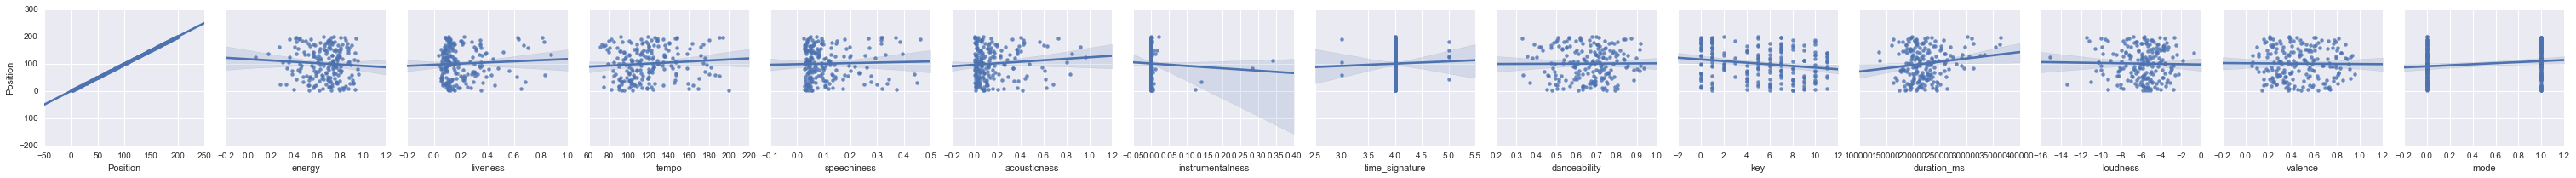

In [6]:
# Before we really dig in, let's try to visualize any potential relationships in the data.

# Any overall trends we can see right off the bat?
sns.pairplot(df, x_vars=feature_cols, y_vars='Position', kind='reg', size=3)

In [7]:
# Let's look closer at one in particular to keep an eye on.



In [8]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [9]:
# Let's take a look at the shape of our data.

df.shape # 200,20 at the time of this writing. Meaning we have 200 rows and 20 columns.

print X.shape # 200,4. Makes sense; 200 rows still, with 4 features.
print y.shape # 200, . Also makes sense; 200 rows of Popularity, and no other columns.

# print X_train.shape
print X_test.shape

(200, 14)
(200,)
(50, 14)


In [10]:
# Fit a logistic regression model to the data.

logreg = LogisticRegression(C=1.0)
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [11]:
# Moment of truth; let's see how accurate our logistic regression model is at predicting a track's Position


In [13]:
# We can probably do better, let's tune the model a bit and see where that gets us.



In [16]:
# Let's try with a more thorough model using a Random Forest Classifier.


# calculate cross-validated AUC

# cv=3
score = cross_val_score(logreg, X, y, scoring='roc_auc').mean()
print score



# Gauge accuracy (with simple metrics for now)

# make prediction for testing dataset, then check its accuracy.
y_pred_class = logreg.predict(X_test)
print metrics.accuracy_score(y_test, y_pred_class)

# calculate AUC
print metrics.roc_auc_score(y_test, y_pred_prob)

ValueError: Found array with 0 sample(s) (shape=(0, 14)) while a minimum of 1 is required.

In [ ]:
#create and train the random forest
#multi-core CPUs can use: rf = RandomForestClassifier(n_estimators=100, n_jobs=2)
rf = RandomForestClassifier(n_estimators=100)

X_train, X_test, y_train, y_test
rf.fit(train, target)